In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import model_based_agent as mba 
import worm_env as we 
import ensemble_mod_env as eme

from improc import *
import utils as ut
import tab_agents as tab
from datetime import datetime 

In [2]:
detpol = np.zeros((12,12))+1
detpol[:6,:6] = -1
detpol[6:,6:] = -1

def pol_test(mod,folder,sets,
            rand_ep_time = 120,
            eval_ep_time = 120,
            worm_ep_len = 120):
    # Takes a model with reward_on as the policy (>0 light on; <0 light off) and 
    # reward_off as zeros. Runs a random episode followed by an evaluation episode {sets} times.
    # Saves every episode trajectory as rand{i}.pkl or eval{i}.pkl (dicts).
    # Returns rands (list) and evals (list) of reward vectors.
    
    if os.path.isdir(folder):
        raise ValueError('Folder already exists.')
    os.mkdir(folder)
    
    rands,evals,dets = [],[],[]
    worm = we.ProcessedWorm(0,ep_len=worm_ep_len)
    cam,task = init_instruments()
    
    # Random policy
    cp = mod['reward_on'][:,:,0].copy().flatten() 
    np.random.shuffle(cp)
    ant_rand = tab.Q_Alpha_Agent() 
    ant_rand.Qtab = np.zeros(ant_rand.Qtab.shape)
    ant_rand.Qtab[:,1] = cp
    runner_rand = mba.WormRunner(ant_rand, worm, act_spacing=1)
    
    # Test policy
    ant_eval = tab.Q_Alpha_Agent() # Test policy
    ant_eval.Qtab = np.zeros(ant_eval.Qtab.shape)
    ant_eval.Qtab[:,1] = mod['reward_on'][:,:,0].flatten() 
    runner_eval = mba.WormRunner(ant_eval, worm, act_spacing=1)
    
    # Deterministic policy
    ant_det = tab.Q_Alpha_Agent()
    ant_det.Qtab = np.zeros(ant_det.Qtab.shape)
    ant_det.Qtab[:,1] = detpol.flatten()
    runner_det = mba.WormRunner(ant_det, worm, act_spacing=1)
    
    
    for s in range(sets):
        fname_r = folder+f'rand{s}.pkl'
        fname_e = folder+f'eval{s}.pkl'
        fname_d = folder+f'det{s}.pkl'
        print(f'Running set {s}')
        
        dets.append(runner_det.eval_ep(cam,task,fname_d,eval_eps=rand_ep_time//worm_ep_len))
        print(np.mean(dets[s]))
        task.write(0)
        evals.append(runner_eval.eval_ep(cam,task,fname_e,eval_eps=eval_ep_time//worm_ep_len))
        print(np.mean(evals[s]))
        task.write(0)
        rands.append(runner_rand.eval_ep(cam,task,fname_r,eval_eps=rand_ep_time//worm_ep_len))
        print(np.mean(rands[s]))
        task.write(0)

    
    cam.exit()
    task.write(0)
    task.close()
    
    return rands,evals,dets,ant_rand,ant_eval,ant_det

def get_model_from_files(files,lp_frac):
    dh = mba.DataHandler()
    dh.load_df(files[0]+'alls.pkl')
    for f in files[1:]:
        dh.add_df_to_df([f+'alls.pkl'])
    mset = eme.ModelSet(1,frac=1,lp_frac=lp_frac)
    mset.make_models(dh,sm_pars={'lambda':.1,'iters':10})
    return mset.models[0]

def plot_mods(models,vmin=None,vmax=None):
    fig,ax = plt.subplots(len(models),7)
    fig.set_size_inches((15,2*len(models)))
    for m,mod in enumerate(models):
        for i,(key,item) in enumerate(mod.items()):
            if i<4:
                img = ax[m,i].imshow(item[:,:,0],vmin=-180,vmax=180)
            else:
                img = ax[m,i].imshow(item[:,:,0],vmin=vmin,vmax=vmax)
            fig.colorbar(img,ax=ax[m,i])
            ax[m,i].axis('off')
            if m==0:
                ax[m,i].set_title(f'{len(models)} models: {key}')
        ax[m,6].imshow(np.sign(mod['reward_on'][:,:,0]-mod['reward_off'][:,:,0]),vmin=-1,vmax=1)

In [6]:
folder = './Data/Dets'+datetime.now().strftime('%d-%m-%H-%M')+'/'
files = ['./Data/HTFix19-01-18-47/',
           './Data/HTFix19-01-20-29/',
           './Data/HTFix19-01-21-18/',
           './Data/HTFix20-01-09-04/',
           './Data/HTFix20-01-09-42/',
           './Data/HTFix20-01-10-41/',
          ]
files = ['../01_13_reals/'+f[2:] for f in files]
mod = get_model_from_files(files,.4)

On model 0
Penalty 0.17816879028072657


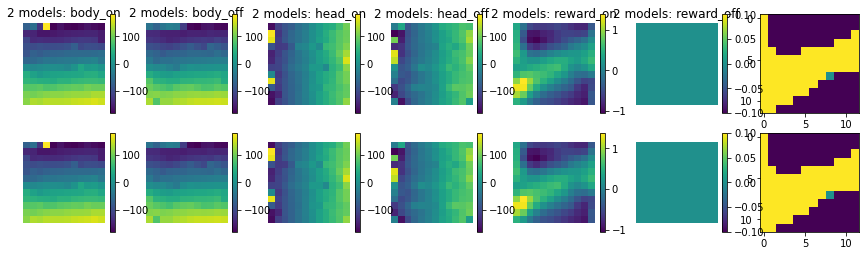

In [7]:
plot_mods([mod,mod])

# Deterministic policy

In [8]:
rands,evals,dets,ant_rand,ant_eval,ant_det = pol_test(mod,folder,2,           
            rand_ep_time = 120,
            eval_ep_time = 120,
            worm_ep_len = 120)

Running set 0
Done resetting	


C:\Users\ccli3\Documents\Research\20_09_07_NewPC\RLWorms\01_22_baselines\improc.py:196: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


-0.13313439322211232
Done resetting	
-0.3655859194071329
Done resetting	
0.14340119934229617
Running set 1
Done resetting	
-0.11077337485612668
Done resetting	
-0.3240019294472035
Done resetting	
-0.0747858402620308


## Looking: something is going wrong

In [2]:
with open('./Data/Dets22-01-16-10/eval0.pkl','rb') as f:
    traj = pickle.load(f)

In [5]:
locs = np.array(traj['loc']).flatten().reshape(-1,2)

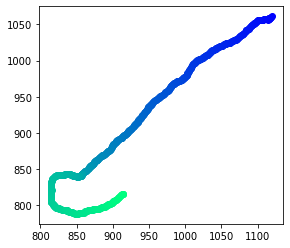

In [7]:
NPOINTS = len(locs)
start = 0
fig,ax = plt.subplots(1)

ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in np.arange(start,start+NPOINTS-1):
    img = ax.scatter(locs[i,0],locs[i,1])
    ax.set_aspect('equal','box')

In [8]:
traj['target']

[90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
